In [21]:
from pandas import read_csv, DataFrame, concat
from statsmodels.tsa.ar_model import AutoReg
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from math import sqrt

In [6]:
series = read_csv('datasets/daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

### Create lagged dataset

In [8]:
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']

X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

### Persistence Model

In [9]:
train_pred = [x for x in train_X]

### Model the training set residuals

In [13]:
train_resid = [train_y[i]-train_pred[i] for i in range(len(train_pred))]
model = AutoReg(train_resid, lags=15)
model_fit = model.fit()
coef = model_fit.params
print('Coef=%s' % (coef))

Coef=[ 0.10120699 -0.84940615 -0.77783609 -0.73345006 -0.68902061 -0.59270551
 -0.5376728  -0.42553356 -0.24861246 -0.19972102 -0.15954013 -0.11045476
 -0.14045572 -0.13299964 -0.12515801 -0.03615774]


This autoregression model requires the residual error of the 15 previous time steps.

### Walk forward forecast (rolling forecast) of residual error

In [18]:
window = 15
history = train_resid[len(train_resid)-window:]
history = [history[i] for i in range (len(history))]
predictions = list()
expected_error = list()

for t in range(len(test_y)):
    # persistence
    yhat = test_X[t]
    # actual error
    error = test_y[t] - yhat
    expected_error.append(error)
    # predict error
    length = len(history)
    lag = [history[i] for i in range(length-window, length)]
    pred_error = coef[0]
    for d in range(window):
        pred_error += coef[d+1] * lag[window-d-1]
    predictions.append(pred_error)
    history.append(error)

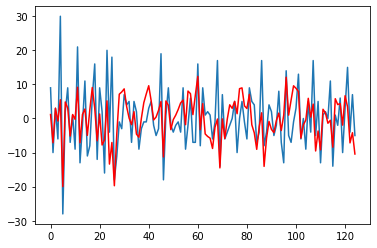

In [19]:
pyplot.plot(expected_error)
pyplot.plot(predictions, color='red')
pyplot.show()

### Correct Predictions with a Model of Residuals
Make better predictions using forecast residual error

improved_forecased = forecast + estimated_error

Test RMSE: 7.649


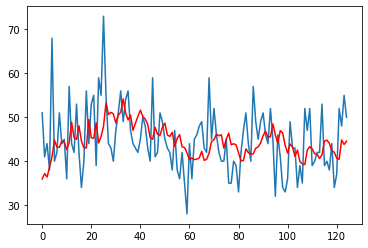

In [23]:
predictions = list()
for t in range(len(test_y)):
    # persistence
    yhat = test_X[t]
    # actual error
    error = test_y[t] - yhat
    expected_error.append(error)
    # predict error
    length = len(history)
    lag = [history[i] for i in range(length-window, length)]
    pred_error = coef[0]
    for d in range(window):
        pred_error += coef[d+1] * lag[window-d-1]
    # correct prediction
    yhat = yhat + pred_error
    predictions.append(yhat)
    history.append(error)
    
rmse = sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)

pyplot.plot(test_y)
pyplot.plot(predictions, color='red')
pyplot.show()